In [67]:
%matplotlib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Create datasets

In [3]:
# !!! rankings.csv file doesn't exist in github
# because it's too big, so I uploaded three separate files 
# of global, finland and sweden yearly rankings instead
rankings=pd.read_csv("./data/ranking.csv")
features=pd.read_csv("./data/features.csv")

In [4]:
# show regions
rankings['Region'].unique()

array(['ec', 'fr', 'ar', 'fi', 'no', 'it', 'lt', 'ph', 'tw', 'nz', 'ee',
       'tr', 'us', 'sv', 'cr', 'de', 'cl', 'jp', 'br', 'hn', 'gt', 'ch',
       'hu', 'ca', 'pe', 'be', 'my', 'dk', 'bo', 'pl', 'at', 'pt', 'se',
       'mx', 'pa', 'uy', 'is', 'es', 'cz', 'ie', 'nl', 'sk', 'co', 'sg',
       'id', 'do', 'lu', 'gb', 'global', 'py', 'au', 'lv', 'gr', 'hk'],
      dtype=object)

In [13]:
# extract yearly rankings for a region
def region_ranking(country_name,country_code):
    # data from region
    region = rankings.loc[rankings['Region']==country_code]
    # yearly aggregated top 100 songs in the region
    region_rankings = region.groupby('Track Name',as_index=False).sum() \
                .sort_values('Streams',ascending=False).reset_index(drop=True)[['Track Name','Streams']][:100]
    # save to csv file
    region_rankings.to_csv("./data/{}_ranking.csv".format(country_name))
    return region_rankings

In [14]:
# extract global, Finland, Sweden yearly ranking
global_rankings = region_ranking('Global','global')
finland_rankings = region_ranking('Finland','fi')
sweden_rankings = region_ranking('Sweden','se')

In [15]:
global_rankings[:5]

,Track Name,Streams
0,Shape of You,1490812208
1,Despacito - Remix,919199404
2,Despacito (Featuring Daddy Yankee),742841612
3,Something Just Like This,692404365
4,Unforgettable,678399824


In [16]:
finland_rankings[:5]

,Track Name,Streams
0,Shape of You,15490841
1,Despacito - Remix,11610371
2,Antaudun,10907969
3,rockstar,9564494
4,Rahan takii,9162255


In [18]:
sweden_rankings[:5]

,Track Name,Streams
0,Shape of You,63869649
1,Despacito - Remix,49631835
2,Something Just Like This,34080940
3,More Than You Know,31980308
4,Symphony (feat. Zara Larsson),31068787


### Checking data quality

In [24]:
# missing values
pd.isna(rankings).sum()

Position        0
Track Name    657
Artist        657
Streams         0
URL             8
Date            0
Region          0
dtype: int64

In [39]:
# rows that contain missing values
na_rows = rankings[rankings.isnull().any(axis=1)]
# missing track name and artist is caused by the song being removed from spotify
# we can simply ignore missing songs, we can't do anything about it anyways
na_rows['URL'][:5]

39428    https://open.spotify.com/track/3RXkboS74UYzN14...
39456    https://open.spotify.com/track/4JAyIDXOqNM6qHu...
39463    https://open.spotify.com/track/3bVbQvGVIe4n24A...
39490    https://open.spotify.com/track/3eFJqPe8VUYrABb...
39631    https://open.spotify.com/track/3RXkboS74UYzN14...
Name: URL, dtype: object

### Preliminary Exploratory Data Analysis

Text(0.5,1.05,'Total yearly number of streams per region')

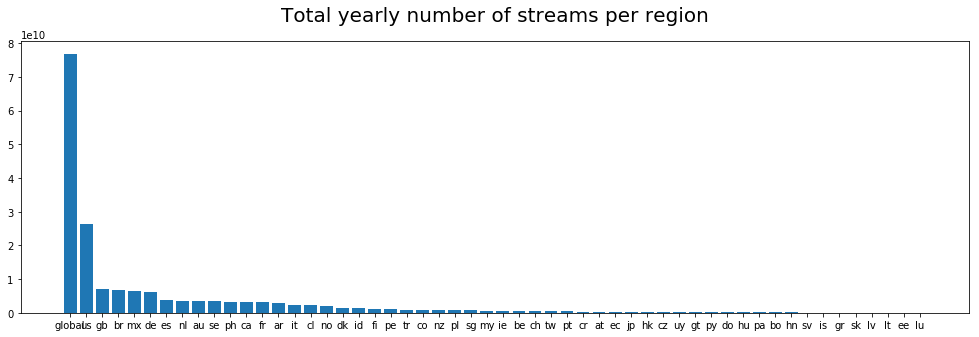

In [70]:
# regional streaming count
streams = rankings['Streams'].groupby(rankings['Region']).sum()
streams_per_region = pd.DataFrame({'Region':streams.index, 'Streams':streams.values}).sort_values('Streams',ascending=False)
plt.figure(figsize=(17,5))
plt.bar(streams_per_region['Region'],streams_per_region['Streams'])
plt.title('Total yearly number of streams per region',size=20,y=1.05)